In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import datetime as dt
import sys
import os
import torch
from SVR_kde.kde_nn import PercentileThresholdKDE, plot_anomaly_results, load_data,find_optimal_percentile
from utils import ReplayBufferAbiomed
sys.path.append('/home/ubuntu/')
from noisy_mujoco.abiomed_env.rl_env import AbiomedRLEnvFactory


env = AbiomedRLEnvFactory.create_env(
									model_name="10min_1hr_all_data",
									model_path=None,
									data_path=None,
									max_steps=6,
									action_space_type="continuous",
									reward_type="smooth",
									normalize_rewards=True,
									seed=42,
									device = f"cuda:1"
									)
dataset1 = env.world_model.data_train
dataset2 = env.world_model.data_val
dataset3 = env.world_model.data_test
dataset = [dataset1, dataset2, dataset3]
all_x = torch.cat([dataset[0].data, dataset[1].data, dataset[2].data], axis=0)
all_pl = torch.cat([dataset[0].pl, dataset[1].pl, dataset[2].pl], axis=0)
all_labels = torch.cat([dataset[0].labels, dataset[1].labels, dataset[2].labels], axis=0)

<module 'noisy_mujoco.abiomed_env.config' from '/home/ubuntu/noisy_mujoco/abiomed_env/config.py'>
time series transformer device cuda:1
Using device: cuda:1
Model loaded from /abiomed/downsampled/models/10min_1hr_all_data_model.pth
loaded datasets with length 
 train:  12051 
 val:  1938 
 test:  3876
Data loaded from /abiomed/downsampled/10min_1hr_all_data.pkl
Continuous action space. Min action: -2.2312597235306466, Max action: 1.8085589693336617


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/ubuntu/noisy_mujoco/abiomed_env/model.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allow

In [2]:
# do tsne reuction on dataset
from sklearn.manifold import TSNE
def tsne_reduction(dataset, n_components=2, perplexity=30, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter)
    tsne.fit(dataset[0].values)
    reduced_train  = tsne.fit_transform(dataset[0].values)
    reduced_val = tsne.fit_transform(dataset[1].values)
    reduced_test = tsne.fit_transform(dataset[2].values)
    return [reduced_train, reduced_val, reduced_test]

In [3]:
#plot tsne for 3 datasets
def plot_tsne(tsne_data1, tsne_data2, tsne_data3, labels, title):
    ax = plt.figure(figsize=(10, 8))
    plt.scatter(tsne_data1[:, 0], tsne_data1[:, 1],  color='red', alpha=0.7, label='train')
    plt.scatter(tsne_data2[:, 0], tsne_data2[:, 1],  color='blue', alpha=0.7, label='val')
    plt.scatter(tsne_data3[:, 0], tsne_data3[:, 1], color='green', alpha=0.7, label='test')

    # plt.colorbar(ax)
  

    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()


In [18]:
data = torch.concat([all_x, all_pl.reshape(all_x.shape[0],all_x.shape[1],1)], axis=2)

In [13]:
# reduced_D_all = tsne_reduction(pd.DataFrame(all_x.reshape(all_x.shape[0],-1)), n_components=2, perplexity=30, n_iter=1000)
# reduced_D_train = tsne_reduction(pd.DataFrame(dataset1.data.reshape(dataset1.data.shape[0],-1)), n_components=2, perplexity=30, n_iter=1000)
# reduced_D_val = tsne_reduction(pd.DataFrame(dataset2.data.reshape(dataset2.data.shape[0],-1)), n_components=2, perplexity=30, n_iter=1000)
# reduced_D_test = tsne_reduction(pd.DataFrame(dataset3.data.reshape(dataset3.data.shape[0],-1)), n_components=2, perplexity=30, n_iter=1000)

reduced = tsne_reduction([pd.DataFrame(dataset1.data.reshape(dataset1.data.shape[0],-1)), 
                          pd.DataFrame(dataset2.data.reshape(dataset2.data.shape[0],-1)),
                          pd.DataFrame(dataset3.data.reshape(dataset3.data.shape[0],-1))])

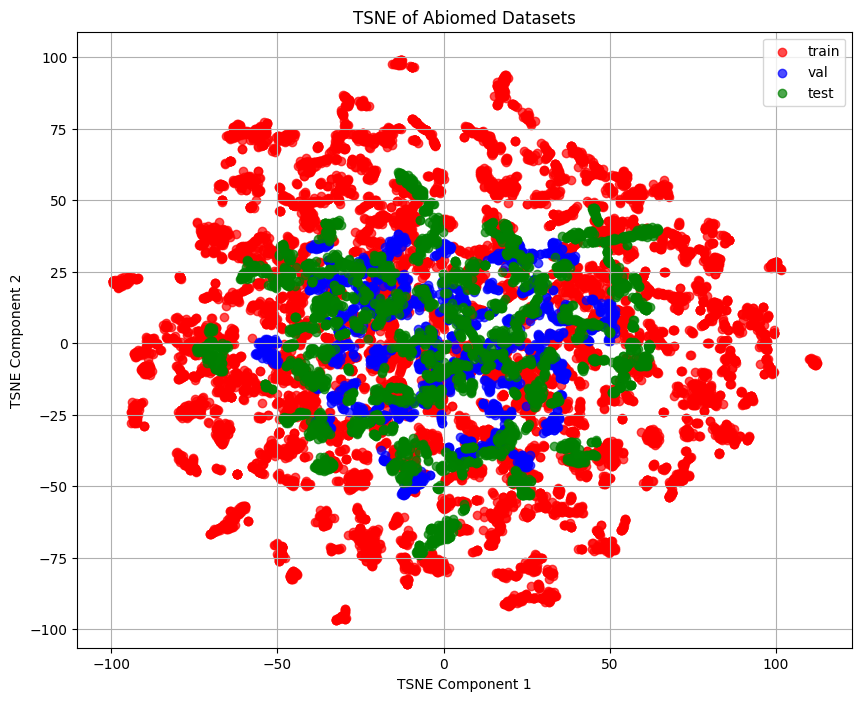

In [14]:
plot_tsne(np.array(reduced[0]).reshape(-1,2), 
          np.array(reduced[1]).reshape(-1,2), 
          np.array(reduced[2]).reshape(-1,2), 
          all_labels, 
          title="TSNE of Abiomed Datasets")

In [5]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 

replay_buffer = ReplayBufferAbiomed(state_dim, action_dim)
replay_buffer.convert_abiomed(dataset, env)
X = np.concatenate([replay_buffer.state, replay_buffer.action], axis=1)
n_samples = len(X)
test_size = 0.2
validation_size = 0.1

test_end = int(n_samples * (1 - test_size))
val_end = int(test_end * (1 - validation_size))

train_idx = np.arange(0, val_end)
val_idx = np.arange(val_end, test_end)
test_idx = np.arange(test_end, n_samples)
X_train = X[train_idx]
X_val = X[val_idx] if len(val_idx) > 0 else None
X_test = X[test_idx]






torch.Size([17865, 6, 12]) torch.Size([17865, 6]) torch.Size([17865, 66])


100%|██████████| 17865/17865 [00:06<00:00, 2723.57it/s]


-4.428163142542622 165.93485669748776
-2.736237 1.3035817
-5.897560220908415 83.67061508289387
-2.0 0.6392697494459261
1.0 1.0


In [9]:
from sklearn.model_selection import train_test_split

test_size = 0.1
validation_size = 0.1
# Shuffle and split data
X_train, X_test_val = train_test_split(X, test_size=test_size+validation_size, random_state=42, shuffle=True)
if validation_size > 0:
    X_val, X_test = train_test_split(X_test_val, test_size=test_size/(test_size+validation_size), random_state=42, shuffle=True)

optimal_percentile, search_results = find_optimal_percentile(
            X_train, X_val,
            bandwidth=1,
            n_neighbors=100,
            use_gpu=True,
            metric='separation'
        )
percentile_to_use = optimal_percentile
model = PercentileThresholdKDE(
    bandwidth=1.0,
    n_neighbors=100,
    use_gpu=True,
    normalize=False,
    percentile=optimal_percentile,
    pca = False,
    devid = 1
)
model.fit(X_train)
# classifier_dict = PercentileThresholdKDE.load_model(f"/abiomed/models/kde/abiomed/trained_kde_abiomed", use_gpu=True, devid =1)
# model = classifier_dict['model']
test_predictions = model.predict(X_test)
test_scores = model.score_samples(X_test)
test_anomaly_scores = model.predict(X_test)
train_anomaly_scores = model.predict(X_train)
val_anomaly_scores = model.predict(X_val)


=== Finding Optimal Percentile (Unsupervised) ===
Testing percentiles: [1, 2, 3, 5, 7, 10, 15, 20]
Optimization metric: separation
Testing percentile: 1%
  Score: 1.7088, Anomaly rate: 33.1%, Threshold: -4.6052
Testing percentile: 2%
  Score: 1.7048, Anomaly rate: 33.4%, Threshold: -4.6051
Testing percentile: 3%
  Score: 1.7010, Anomaly rate: 33.6%, Threshold: -4.6044
Testing percentile: 5%
  Score: 1.6938, Anomaly rate: 34.0%, Threshold: -4.6001
Testing percentile: 7%
  Score: 1.6846, Anomaly rate: 34.7%, Threshold: -4.5898
Testing percentile: 10%
  Score: 1.6711, Anomaly rate: 35.7%, Threshold: -4.5597
Testing percentile: 15%
  Score: 1.6444, Anomaly rate: 37.9%, Threshold: -4.4637
Testing percentile: 20%
  Score: 1.6141, Anomaly rate: 41.0%, Threshold: -4.3231

Best percentile: 1% (Score: 1.7088)
Training on 14292 samples with 73 features
Percentile threshold: 1%
Bandwidth: 1.0, K-neighbors: 100
Using GPU acceleration
Computing density scores for threshold...
Fitting completed in 1

In [10]:
reduced = tsne_reduction([pd.DataFrame(X_train), 
                          pd.DataFrame(X_val),
                          pd.DataFrame(X_test)])


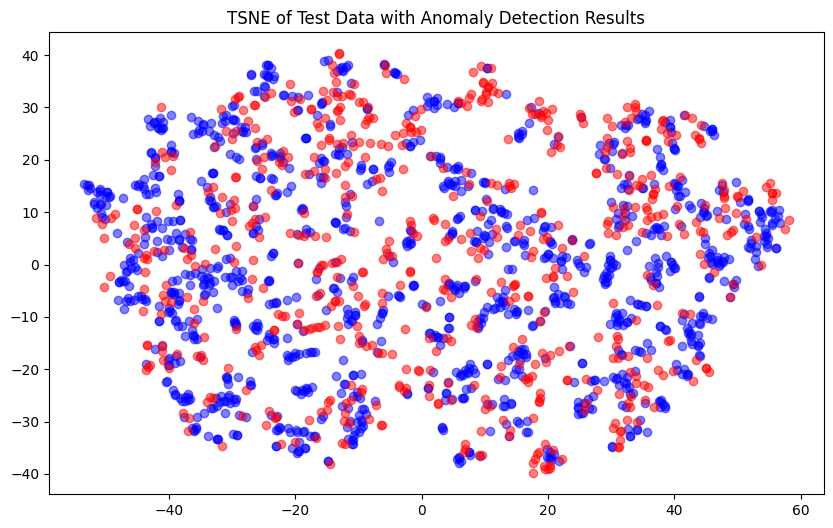

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced[2][test_predictions == 1, 0], reduced[2][test_predictions == 1, 1], 
            color='blue', label='ID', alpha=0.5)
plt.scatter(reduced[2][test_predictions == -1, 0], reduced[2][test_predictions == -1, 1], 
            color='red', label='OOD', alpha=0.5)
plt.title('TSNE of Test Data with Anomaly Detection Results')
plt.show()

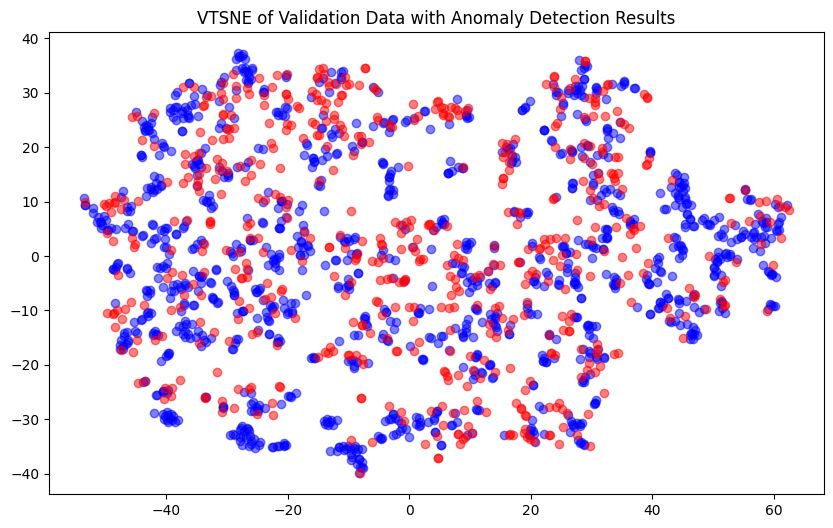

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced[1][val_anomaly_scores == 1, 0], reduced[1][val_anomaly_scores == 1, 1], 
            color='blue', label='ID', alpha=0.5)
plt.scatter(reduced[1][val_anomaly_scores == -1, 0], reduced[1][val_anomaly_scores == -1, 1], 
            color='red', label='OOD', alpha=0.5)
plt.title('VTSNE of Validation Data with Anomaly Detection Results')
plt.show()

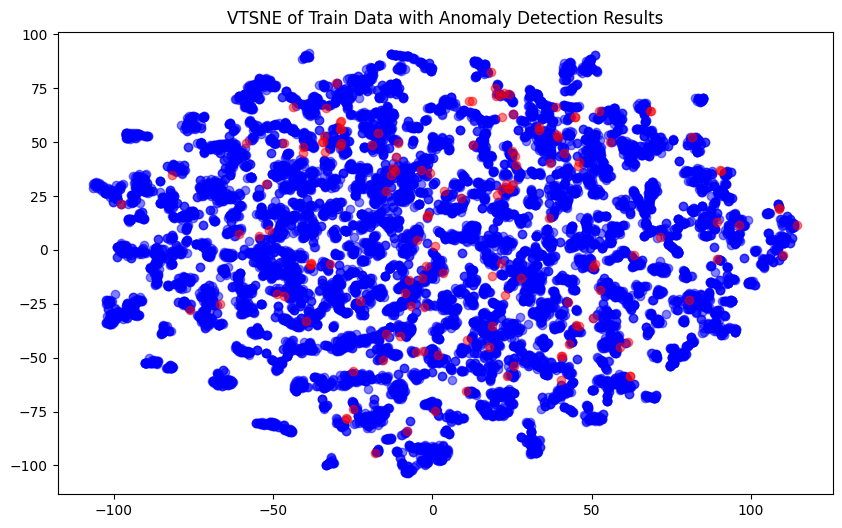

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced[0][train_anomaly_scores == 1, 0], reduced[0][train_anomaly_scores == 1, 1], 
            color='blue', label='ID', alpha=0.5)
plt.scatter(reduced[0][train_anomaly_scores == -1, 0], reduced[0][train_anomaly_scores == -1, 1], 
            color='red', label='OOD', alpha=0.5)
plt.title('VTSNE of Train Data with Anomaly Detection Results')
plt.show()

In [50]:
np.unique(train_anomaly_scores, return_counts=True), np.unique(val_anomaly_scores, return_counts=True), np.unique(test_anomaly_scores, return_counts=True)

((array([-1,  1]), array([  122, 12740])),
 (array([-1,  1]), array([942, 488])),
 (array([-1,  1]), array([1886, 1687])))

In [51]:
model.save_model(os.path.join(f"/abiomed/models/kde/abiomed/trained_kde_abiomed_1")) 

Transfering from gpu to cpu for saving...
Model saved to /abiomed/models/kde/abiomed/trained_kde_abiomed_1.faiss and /abiomed/models/kde/abiomed/trained_kde_abiomed_1_metadata.pkl


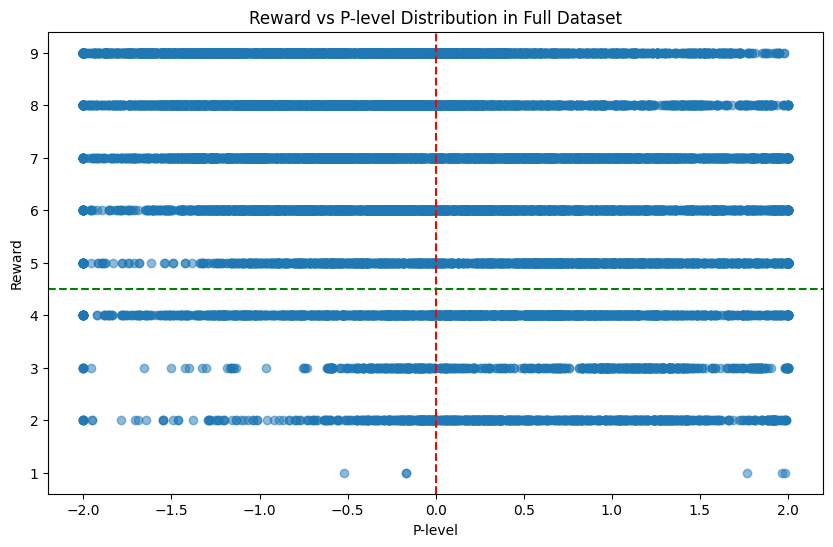

In [6]:
#scatter plot of action vs reward in train set
plt.figure(figsize=(10, 6))
plt.scatter(replay_buffer.reward,env.world_model.unnorm_pl(replay_buffer.action), alpha=0.5, label='Train Actions')
#put a vertical  line at 0
plt.axvline(x=0, color='red', linestyle='--', label='Zero Reward Line')
#put a horizontal line at 4.5
plt.axhline(y=4.5, color='green', linestyle='--', label='Max P-level Line')
plt.xlabel('P-level')
plt.ylabel('Reward')


plt.title('Reward vs P-level Distribution in Full Dataset')

plt.show()

In [64]:
with open("/abiomed/downsampled/10min_1hr_all_data.pkl", "rb") as f:
    data = pd.read_pickle(f)

In [71]:
data['train'][...,-1].min(), data['train'][...,-1].max()

(tensor(1., dtype=torch.float64), tensor(9., dtype=torch.float64))